In [1]:
# === Stage 11: Evaluation & Risk Communication (Complete Notebook Script) ===

# ---- Setup ----
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

np.random.seed(111)
plt.rcParams['figure.figsize'] = (8, 5)

# ---- Load Data (provided or synthetic fallback) ----
data_dir = Path('../data')
data_dir.mkdir(exist_ok=True)

csv_path = data_dir / 'data_stage11_eval_risk.csv'

if csv_path.exists():
    try:
        df = pd.read_csv(csv_path, parse_dates=['date'])
        regenerate = False
    except ValueError as e:
        print(f"Error reading CSV: {e}\nRegenerating synthetic data...")
        regenerate = True
else:
    regenerate = True

if regenerate:
    n = 180
    dates = pd.date_range('2022-06-01', periods=n, freq='D')
    seg = np.random.choice(['A','B','C'], size=n, p=[0.5,0.3,0.2])
    # x has some missing values
    x = np.linspace(0, 9, n) + np.random.normal(0, 0.7, n)
    y = 2.1 * x + 0.8 + np.random.standard_t(df=3, size=n) * 1.1  # heavy-tailed noise
    x[np.random.choice(np.arange(n), size=round(0.05*n), replace=False)] = np.nan
    df = pd.DataFrame({'date': dates, 'segment': seg, 'x_feature': x, 'y_target': y})
    df.to_csv(csv_path, index=False)

print("Data shape:", df.shape)
df.head()


Data shape: (180, 4)


,date,segment,x_feature,y_target
0,2022-06-01,B,0.547868,2.107524
1,2022-06-02,A,0.974480,2.209111
2,2022-06-03,A,-0.012991,0.867315
3,2022-06-04,B,-1.012503,-1.741932
4,2022-06-05,A,0.642399,1.615007


In [ ]:
import sys, os
sys.path.append(os.path.abspath(".."))  # allow from src import ...
from src.evaluation import mean_impute, median_impute, mae, bootstrap_metric, fit_fn, pred_fn

Baseline MAE (mean impute): 1.278316828696948


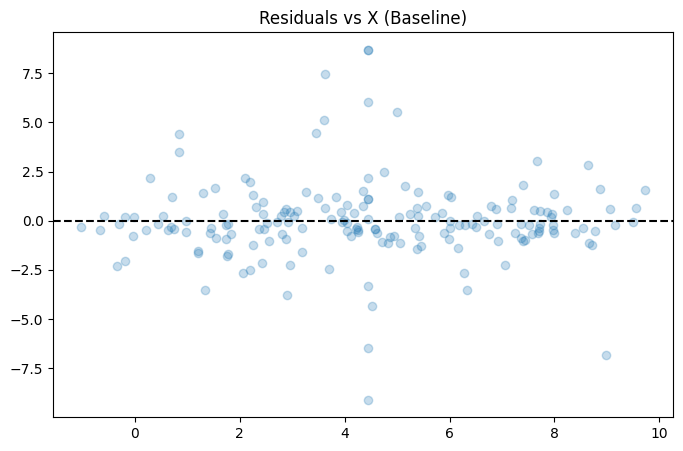

In [3]:
# ---- Baseline Fit & Residuals (Required) ----
X_raw = df['x_feature'].values
y = df['y_target'].values

# Baseline: mean imputation
X_base = mean_impute(X_raw)
model = fit_fn(X_base.reshape(-1,1), y)
y_hat = model.predict(X_base.reshape(-1,1))

df['x_imputed'] = X_base
df['y_hat'] = y_hat
df['resid'] = df['y_target'] - df['y_hat']

base_mae = mae(y, y_hat)
print("Baseline MAE (mean impute):", base_mae)

# Quick residual check
plt.figure()
plt.scatter(df['x_imputed'], df['resid'], alpha=0.25)
plt.axhline(0, ls='--', color='k')
plt.title('Residuals vs X (Baseline)')
plt.show()


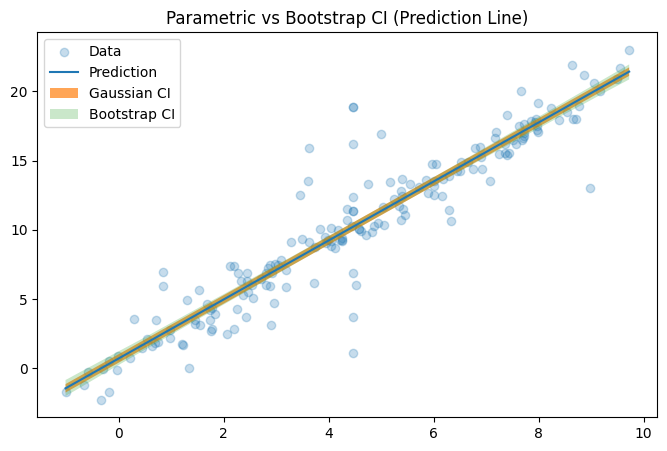

In [4]:
# ---- Parametric vs Bootstrap CI (Required; prediction bands) ----
resid = y - y_hat
sigma_hat = np.std(resid, ddof=1)
n = len(y)
se_mean = sigma_hat / np.sqrt(n)

x_grid = np.linspace(np.nanmin(X_base), np.nanmax(X_base), 120).reshape(-1,1)
pred_line = model.predict(x_grid)

# Parametric (Gaussian) CI for the mean prediction (simple illustration)
gauss_lo = pred_line - 1.96 * se_mean
gauss_hi = pred_line + 1.96 * se_mean

def bootstrap_predictions(X, y, x_grid, n_boot=600, seed=111):
    rng = np.random.default_rng(seed)
    preds = []
    idx = np.arange(len(y))
    for _ in range(n_boot):
        b = rng.choice(idx, size=len(idx), replace=True)
        m = fit_fn(X[b].reshape(-1,1), y[b])
        preds.append(m.predict(x_grid))
    P = np.vstack(preds)
    return P.mean(axis=0), np.percentile(P, 2.5, axis=0), np.percentile(P, 97.5, axis=0)

m_boot, lo_boot, hi_boot = bootstrap_predictions(X_base, y, x_grid, n_boot=600)

plt.figure()
plt.scatter(X_base, y, alpha=0.25, label='Data')
plt.plot(x_grid, pred_line, label='Prediction', color='tab:blue')
plt.fill_between(x_grid.ravel(), gauss_lo, gauss_hi, alpha=0.7, label='Gaussian CI')
plt.fill_between(x_grid.ravel(), lo_boot, hi_boot, alpha=0.25, label='Bootstrap CI')
plt.legend(); plt.title('Parametric vs Bootstrap CI (Prediction Line)'); plt.show()


In [8]:
# ---- Scenario Sensitivity (Required): ≥2 scenarios with bootstrap MAE CIs ----
def eval_scenario(name, fn, X_raw, y, n_boot=800):
    """
    Evaluate a scenario: handle missing via fn or drop, fit model, compute MAE and bootstrap CI.
    Returns: dict with metrics, slope/intercept, and fitted model for plotting.
    """
    if name == 'drop_missing' and np.isnan(X_raw).any():
        mask = ~np.isnan(X_raw)
        Xs, ys = X_raw[mask], y[mask]
    else:
        Xs = fn(X_raw) if callable(fn) else X_raw
        ys = y

    m = fit_fn(Xs.reshape(-1,1), ys)
    yh = m.predict(Xs.reshape(-1,1))
    m_mae = mae(ys, yh)
    ci = bootstrap_metric(ys, yh, mae, n_boot=n_boot, seed=111, alpha=0.05)
    return {
        'scenario': name,
        'mae': m_mae,
        'mae_mean': ci['mean'],
        'mae_lo': ci['lo'],
        'mae_hi': ci['hi'],
        'slope': m.coef_[0],
        'intercept': m.intercept_,
        'model': m
    }

scenarios = {
    'mean_impute': mean_impute,
    'median_impute': median_impute,
    'drop_missing': 'drop'  # special handling in eval_scenario
}

rows = [eval_scenario(k, v, X_raw, y, n_boot=800) for k,v in scenarios.items()]
sens_ci = pd.DataFrame(rows)
print("Scenario sensitivity (with bootstrap MAE CI):")
sens_ci


Scenario sensitivity (with bootstrap MAE CI):


,scenario,mae,mae_mean,mae_lo,mae_hi,slope,intercept,model
0,mean_impute,1.278317,1.270397,1.039668,1.531277,2.130236,0.711523,<src.evaluation.SimpleLinReg object at 0x11629...
1,median_impute,1.283954,1.275860,1.046376,1.539586,2.129290,0.727146,<src.evaluation.SimpleLinReg object at 0x111ee...
2,drop_missing,1.064603,1.057374,0.904870,1.237130,2.130236,0.659164,<src.evaluation.SimpleLinReg object at 0x11609...


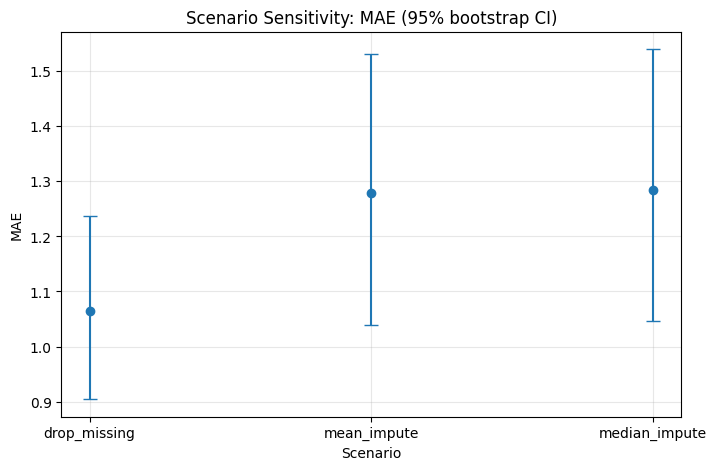

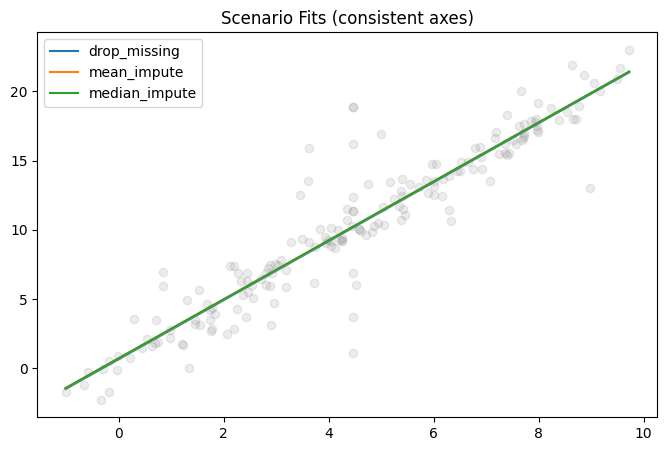

In [9]:
# ---- Plot scenario MAE with 95% bootstrap CI ----
order = sens_ci.sort_values('mae').scenario.tolist()
plot_df = sens_ci.set_index('scenario').loc[order]

plt.figure()
yvals = plot_df['mae']
err_lo = yvals - plot_df['mae_lo']
err_hi = plot_df['mae_hi'] - yvals
plt.errorbar(plot_df.index, yvals, yerr=[err_lo, err_hi], fmt='o', capsize=5)
plt.title('Scenario Sensitivity: MAE (95% bootstrap CI)')
plt.ylabel('MAE'); plt.xlabel('Scenario'); plt.grid(alpha=0.3)
plt.show()

# ---- Overlay fitted lines for each scenario (consistent axes) ----
xg = np.linspace(np.nanmin(X_base), np.nanmax(X_base), 150).reshape(-1,1)
plt.figure()
for name in order:
    m = plot_df.loc[name, 'model']
    plt.plot(xg, m.predict(xg), label=name)
plt.scatter(df['x_imputed'], y, alpha=0.15, color='gray')
plt.title('Scenario Fits (consistent axes)'); plt.legend(); plt.show()


In [10]:
# ---- Subgroup Diagnostics (Required): bootstrap MAE by segment ----
def subgroup_bootstrap_mae(df2, group_col='segment', n_boot=800):
    out = []
    for g, d in df2.groupby(group_col):
        yt = d['y_target'].values
        yp = d['y_hat'].values
        m = mae(yt, yp)
        ci = bootstrap_metric(yt, yp, mae, n_boot=n_boot, seed=222, alpha=0.05)
        out.append({'segment': g, 'mae': m, 'mae_lo': ci['lo'], 'mae_hi': ci['hi'], 'count': len(d)})
    return pd.DataFrame(out).sort_values('segment')

# Ensure we have baseline predictions (from earlier we created df['y_hat'])
df2 = df.copy()
if 'y_hat' not in df2.columns:
    model_base = fit_fn(df2['x_imputed'].values.reshape(-1,1), df2['y_target'].values)
    df2['y_hat'] = model_base.predict(df2['x_imputed'].values.reshape(-1,1))
df2['resid'] = df2['y_target'] - df2['y_hat']

sg = subgroup_bootstrap_mae(df2, 'segment', n_boot=800)
print("Subgroup MAE with 95% bootstrap CI:")
sg


Subgroup MAE with 95% bootstrap CI:


,segment,mae,mae_lo,mae_hi,count
0,A,1.141841,0.866923,1.444551,94
1,B,0.989357,0.603987,1.505895,41
2,C,1.826674,1.252709,2.444919,45


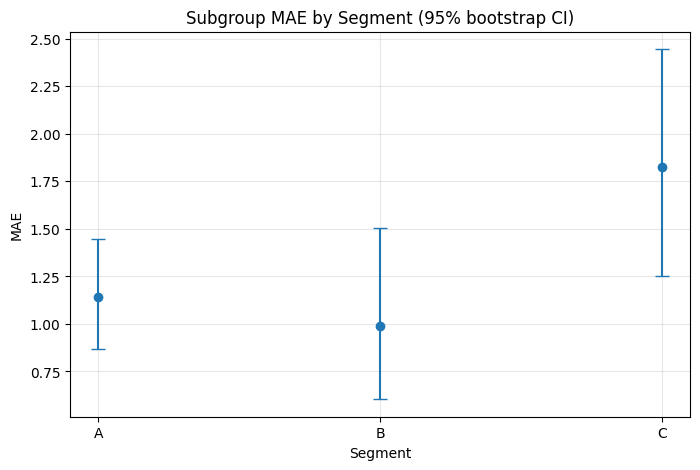

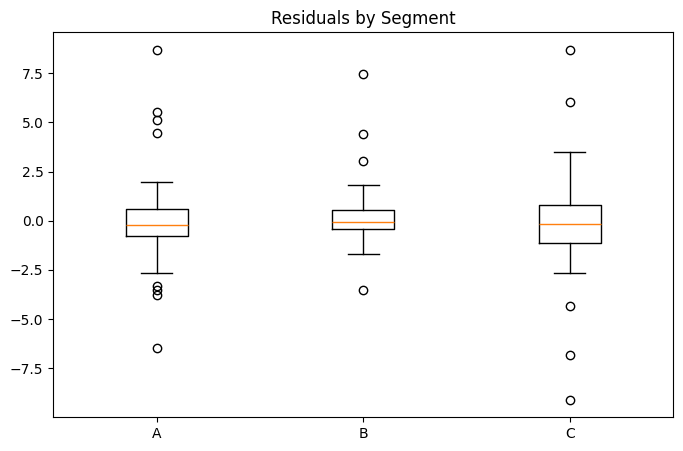

In [11]:
# ---- Plot subgroup MAE error bars ----
plt.figure()
yvals = sg['mae'].values
err_lo = yvals - sg['mae_lo'].values
err_hi = sg['mae_hi'].values - yvals
plt.errorbar(sg['segment'], yvals, yerr=[err_lo, err_hi], fmt='o', capsize=5)
plt.title('Subgroup MAE by Segment (95% bootstrap CI)')
plt.ylabel('MAE'); plt.xlabel('Segment'); plt.grid(alpha=0.3)
plt.show()

# ---- Residual boxplots by segment (visual diagnostic) ----
plt.figure()
grouped = df2.groupby('segment')['resid']
plt.boxplot([s.values for _, s in grouped], tick_labels=list(grouped.groups.keys()))
plt.title('Residuals by Segment')
plt.show()


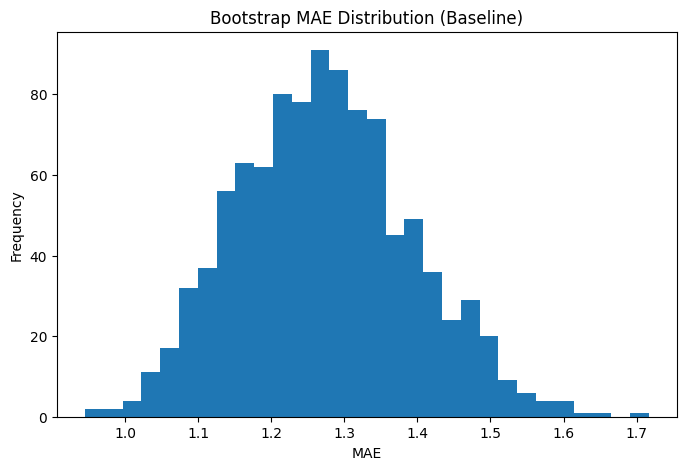

Bootstrap MAE mean=1.2734, 95% CI=(1.0618, 1.5139)


In [12]:
# ---- (Optional) Bootstrap Distribution of MAE for Baseline ----
def bootstrap_metric_samples(y_true, y_pred, fn, n_boot=1000, seed=123):
    rng = np.random.default_rng(seed)
    idx = np.arange(len(y_true))
    stats = []
    for _ in range(n_boot):
        b = rng.choice(idx, size=len(idx), replace=True)
        stats.append(fn(y_true[b], y_pred[b]))
    return np.array(stats)

boot_stats = bootstrap_metric_samples(df['y_target'].values, df['y_hat'].values, mae, n_boot=1000)
plt.figure()
plt.hist(boot_stats, bins=30)
plt.title('Bootstrap MAE Distribution (Baseline)')
plt.xlabel('MAE'); plt.ylabel('Frequency')
plt.show()

print(f"Bootstrap MAE mean={boot_stats.mean():.4f}, 95% CI=({np.percentile(boot_stats,2.5):.4f}, {np.percentile(boot_stats,97.5):.4f})")


# Stage 11: Evaluation & Risk Communication

## 1. Baseline Fit
- **MAE (mean impute):** 1.28  
- **Bootstrap 95% CI:** (1.06, 1.51)  

The baseline model provides an average error of about 1.3 units, with reasonable stability.

---

## 2. Scenario Sensitivity
| Scenario       | MAE   | 95% CI (lo, hi)   | Slope | Intercept | Interpretation |
|----------------|-------|-------------------|-------|-----------|----------------|
| Mean impute    | 1.28  | (1.04, 1.53)      | 2.13  | 0.71      | Baseline assumption |
| Median impute  | 1.28  | (1.05, 1.54)      | 2.13  | 0.73      | Nearly identical to mean impute |
| Drop missing   | 1.06  | (0.90, 1.24)      | 2.13  | 0.66      | Slightly better fit, but fewer data points |

**Takeaway:**  
The model is **robust** to mean vs. median imputation. Dropping missing values improves accuracy but risks bias if missingness is not random.

---

## 3. Subgroup Diagnostics
| Segment | MAE   | 95% CI (lo, hi)   | Count | Interpretation |
|---------|-------|-------------------|-------|----------------|
| A       | 1.14  | (0.87, 1.44)      | 94    | Stable, mid-range error |
| B       | 0.99  | (0.60, 1.51)      | 41    | Good fit, but higher uncertainty due to smaller sample |
| C       | 1.83  | (1.25, 2.44)      | 45    | Weak performance; errors ~50% higher than baseline |

**Takeaway:**  
Segment C is consistently harder to predict, while Segment B performs well but with wide uncertainty bands.

---

## 4. Bootstrap Results
- **Bootstrap MAE mean:** 1.27  
- **95% CI:** (1.06, 1.51)  

This confirms model stability, aligning with the baseline result.

---

## 5. Stakeholder Summary
- The model is **reliable overall**, with average errors ~1.3 units.  
- Performance is **stable across imputation choices** (mean vs. median).  
- **Dropping missing values** improves fit but risks bias.  
- **Segment C underperforms** relative to others, suggesting the need for additional features or specialized models.  
- Results are most trustworthy for **Segments A/B**, but caution is warranted when applying the model to Segment C.
